<a href="https://colab.research.google.com/github/sun-gif/Deep-learning/blob/master/randommask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [2]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

In [3]:
import transformers
from transformers import AutoTokenizer, AutoModel

In [64]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

text = ['From my grandfather Verus I learned good morals and the government of my temper.',
 'From the reputation and remembrance of my father, modesty and a manly character.',
 'From my mother, piety and beneficence, and abstinence, not only from evil deeds, but even from evil thoughts; and further, simplicity in my way of living, far removed from the habits of the rich.',
 'From my great-grandfather, not to have frequented public schools, and to have had good teachers at home, and to know that on such things a man should spend liberally.']

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
import pandas as pd
t=pd.read_csv('/content/senor_results.tsv',sep="\t")

In [6]:
def mask_seq(row):
    tokens = tokenizer(row.context, return_tensors='pt',max_length=512, truncation=True,padding='max_length')   
    start = tokens.char_to_token(row.start)
    end = tokens.char_to_token(row.end)
    #print(start,end)
    tokens['attention_mask'] = torch.tensor([0 if (a >= start and a < end) else 1 for a in range(tokens['input_ids'].shape[1]) ])
    return tokens

In [82]:
class MeditationsDataset():
    def __init__(self, data):
        self.data=data
        self.mask_seq=mask_seq
        self.inputs=[]
    def __getitem__(self, idx):
        self.inputs.append(self.mask_seq(self.data.iloc[idx]))
        #print(self.inputs)
        self.inputs[idx]['labels'] = self.inputs[idx].input_ids.detach().clone()
        #print(self.inputs)
        return self.inputs[idx]
        #return {key: torch.tensor(val[idx]) for key, val in self.inputs[idx].items()}
    def __len__(self):
        return len(self.data)

In [91]:
dataset = MeditationsDataset(t[:16])

In [143]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [10]:
from transformers import AdamW
# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)
# activate training mode
model.train()

Epoch 0,running_Loss 7.447021424770355
Epoch 1,running_Loss 7.36666601896286
Epoch 2,running_Loss 7.37328964471817
Epoch 3,running_Loss 7.349953711032867
Epoch 4,running_Loss 7.368489682674408


<function matplotlib.pyplot.show>

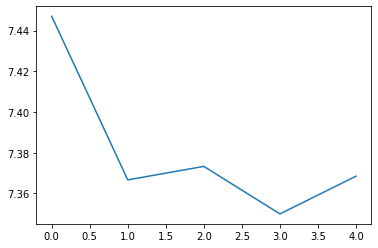

In [145]:
#from tqdm import tqdm  # for our progress bar
import matplotlib
import matplotlib.pyplot as plt
epochs = 5
Loss=[]
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    #loop = tqdm(loader, leave=True)
    #print(loop)
    running_loss = 0
    for batch in loader:
        #batch=torch.squeeze(batch)
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = torch.squeeze(batch['input_ids'],0).to(device)
        #input_ids = batch['input_ids'].to(device)
        #print(input_ids.shape)
        attention_msk=(batch['attention_mask']).to(device)
        #attention_mask = torch.squeeze(batch['attention_mask']).to(device)
        #labels = batch['labels'].to(device)
        labels = torch.squeeze(batch['labels'],0).to(device)
        #print(attention_msk.shape)
        outputs = model(input_ids,labels=labels,attention_mask=attention_msk)
        # process
        #print(outputs.shape)
        # extract loss
        loss = outputs.loss
        #print(loss)
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        #loop.set_description(f'Epoch {epoch}')
        #loop.set_postfix(loss=loss.item())
        running_loss += loss.item()
       #print('Epoch {}, Loss {}'.format(epoch, loss.item()))
    print( 'Epoch {},running_Loss {}'.format(epoch,running_loss/len(loader))) 
    
    Loss.append(running_loss/len(loader))    
plt.plot(Loss)
plt.show